<a href="https://colab.research.google.com/github/NikitaKarabeinikau/COVID19_Outbreak_Simulation/blob/master/ProbProgProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projekt z programowania probabilistycznego

Każda grupa ma osobny zestaw danych do opracowania. Każdy zestaw składa się z 2500 próbek opisujących oceny filmów przez różnych ludzi. Każdy rekord zawiera następujące informacje:

1.   id filmu
2.   id osoby wystawiającej ocenę
3.   id gatunku do którego należy film
4.   ocenę wystawioną przez określoną osobę określonemu filmowi

Każda baza danych obejmuje 200 filmów należących do 5 gatunków. Filmy oceniane były przez 25 ludzi. Ta sama osoba mogła wystawić więcej niż jedną ocenę jeżli widziała określony film wielokrotnie.

Dla uproszczenia analizy oceny filmów są liczbami rzeczywistymi, mogą być zarówno dodatnie jak i ujemne.

W ramach projektu trzeba będzie przygotować modele odpowiadające na poniższe pytania.






## Osobno dla każdego modelu opisywanego w sprawozdaniu

Wykonaj sampling z następującymi ustawieniami:
```
trace = pm.sample(5000, tune=1000, target_accept=.9)
```

Czy sampling kończy się sukcesem? Dlaczego tak uważasz? Zapisz w sprawozdaniu wartości `mean`, `sd`, `hpd_3%` i `hpd_97%` dla odchylenia standardowego i 20 pierwszych filmów korzystając z funkcji:
```
arviz.summary(trace)
```
Zanotuj wartości `mean` dla wszystkich filmów.

# Kod do generowania danych testowych

In [ ]:
# Arviz służy do wizualizacji modeli Bayesowskich
!pip install arviz 
!pip install 'pymc3==3.11.2'

In [ ]:
%matplotlib inline
import numpy as np
import theano
import theano.tensor as tt
import pymc3 as pm
import arviz
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_context('notebook')
plt.style.use('seaborn-darkgrid')
print('Running on PyMC3 v{}'.format(pm.__version__))

pd.set_option('display.max_rows', 300)

Running on PyMC3 v3.11.2


In [ ]:
n_genres = 5
n_people = 25
n_movies = 200

def gen_data(n_examples):
  sigma_person = pm.Gamma.dist(alpha=10, beta=5).random()
  sigma_movie = pm.Gamma.dist(alpha=10, beta=5).random()
  sigma_genre = pm.Gamma.dist(alpha=10, beta=5).random()

  d_mu_m = pm.Normal.dist(mu=0.0, sigma=sigma_movie)
  d_mu_g = pm.Normal.dist(mu=0.0, sigma=sigma_genre)
  mu_movie = [d_mu_m.random() for gi in range(n_movies)] # średnia ocena filmu
  mu_genre = [d_mu_g.random() for gi in range(n_genres)] # średnia ocena gatunku
  d_mu_person = pm.Normal.dist(mu=0.0, sigma=sigma_person)

  mu_person = [d_mu_person.random() for _ in range(n_people)] # średnia ocena prez osobę
  d_mu_gp = pm.Normal.dist(mu=0.0, sigma=sigma_person)
  mu_gp = [[d_mu_gp.random() for _ in range(n_people)] for _ in range(n_genres)] # średnia ocena gatunku prez osobę

  d_genre = pm.DiscreteUniform.dist(0, n_genres-1)
  d_person = pm.DiscreteUniform.dist(0, n_people-1)
  d_movie = pm.DiscreteUniform.dist(0, n_movies-1)

  movie_to_genre = [d_genre.random() for _ in range(n_movies)]

  def gen_random():
    movie = d_movie.random()
    person = d_person.random()
    genre = movie_to_genre[movie]
    like = pm.Normal.dist(mu=mu_movie[movie] + mu_genre[genre] + mu_person[person] + mu_gp[genre][person], sigma=sigma_person).random()
    return [movie, person, genre, like]

  df = pd.DataFrame(np.array([gen_random() for _ in range(n_examples)]),
                    columns=['movie', 'person', 'genre', 'like'])
  dataframe = df.astype({"movie": int, "person": int, "genre": int})
  return (dataframe, mu_movie, mu_genre, mu_person, mu_gp, movie_to_genre, sigma_person, sigma_movie, sigma_genre)
  
dataframe, orig_mu_movie, orig_mu_genre, orig_mu_person, mu_gp, movie_to_genre, orig_sigma_person, orig_sigma_movie, orig_sigma_genre = gen_data(2500)

# dataframe -- dane testowe w odpowiednim formacie do analizy
# orig_* -- ukryte zmienne objaśniające które nie są znane

# Można weryfikować poprawność modelu generując nowe dane i sprawdzając czy wygenerowane wartości zmiennych (orig_*) objaśniających mniej więcej odpowiadają tym które zwraca model.


def save_data(id, dataframe, orig_mu_movie, orig_mu_genre, orig_mu_person, mu_gp, movie_to_genre, orig_sigma_person, orig_sigma_movie, orig_sigma_genre):
  dataframe.to_csv(f'/content/drive/My Drive/Colab Notebooks/ProbProbProjData/dataframe {id}.csv')
  with open(f'/content/drive/My Drive/Colab Notebooks/ProbProbProjData/latent {id}.txt', 'w') as f:
    f.write(f'orig_sigma_person = {orig_sigma_person}\n')
    f.write(f'orig_sigma_movie = {orig_sigma_movie}\n')
    f.write(f'orig_sigma_genre = {orig_sigma_genre}\n')
    f.write('orig_mu_movie = \n')
    for i in range(n_movies):
      f.write(f'{i}\t{orig_mu_movie[i]}')
      f.write('\n')
    f.write('orig_mu_genre = \n')
    for i in range(n_genres):
      f.write(f'{i}\t{orig_mu_genre[i]}')
      f.write('\n')
    f.write('orig_mu_person = \n')
    for i in range(n_people):
      f.write(f'{i}\t{orig_mu_person[i]}')
      f.write('\n')
    f.write('movie_to_genre = \n')
    for i in range(n_movies):
      f.write(f'{i}\t{movie_to_genre[i]}')
      f.write('\n')
    f.write('orig_mu_gp = \n')
    for i in range(n_genres):
      f.write(f'{i}')
      for j in range(n_people):
        f.write(f'\t{mu_gp[i][j]}')
      f.write('\n')

# for i in range(100):
#   save_data(i, *gen_data(2500))

print("sigmas", orig_sigma_person, orig_sigma_movie, orig_sigma_genre)
display(dataframe.describe())
display(dataframe)
print("mu_genre")
display(orig_mu_genre)
print("mu_person")
display(orig_mu_person)
print("mu_movie")
display(orig_mu_movie)

sigmas 2.1411509019485453 1.3408587422580593 2.6634337821378846


,movie,person,genre,like
count,2500.000000,2500.000000,2500.00000,2500.000000
mean,98.402800,11.882400,1.85480,0.825281
std,57.265692,7.177993,1.47166,4.730020
min,0.000000,0.000000,0.00000,-12.722321
25%,48.000000,6.000000,0.00000,-2.410795
50%,99.000000,12.000000,2.00000,0.614126
75%,147.000000,18.000000,3.00000,3.828767
max,199.000000,24.000000,4.00000,18.964743


,movie,person,genre,like
0,135,24,1,-0.112940
1,2,9,0,-7.325434
2,81,0,2,5.080932
3,179,7,2,8.902443
4,148,12,4,-1.158360
...,...,...,...,...
2495,177,21,1,-1.012779
2496,65,23,1,9.365624
2497,26,9,2,12.179171
2498,66,6,1,-5.791035


mu_genre


[array(-1.1989679),
 array(0.97584526),
 array(6.28811466),
 array(0.54583073),
 array(-1.36149529)]

mu_person


[array(-2.69957362),
 array(1.22731998),
 array(1.22268613),
 array(-1.31506644),
 array(-2.19537192),
 array(4.4015503),
 array(-2.73693078),
 array(-1.62669406),
 array(-1.76325286),
 array(-1.09614718),
 array(-1.37358375),
 array(-0.5468519),
 array(1.21456075),
 array(-0.15506472),
 array(0.98092282),
 array(-0.27060888),
 array(-1.3885059),
 array(-2.06542225),
 array(0.96988645),
 array(1.82402754),
 array(1.35760066),
 array(1.12534333),
 array(1.9976595),
 array(1.88156323),
 array(1.33593687)]

mu_movie


[array(-0.20508913),
 array(-0.73047817),
 array(-1.19571846),
 array(-0.52334479),
 array(-0.38025781),
 array(-2.23282319),
 array(-0.96487033),
 array(0.38286322),
 array(-0.60464982),
 array(-0.63722857),
 array(3.55047887),
 array(-0.66202687),
 array(-2.31377374),
 array(0.4435618),
 array(-2.42207291),
 array(-1.56987372),
 array(-0.14346068),
 array(-0.08465096),
 array(2.8899509),
 array(-0.59862217),
 array(-0.72176344),
 array(2.23548554),
 array(1.14458533),
 array(-0.10441722),
 array(1.0027948),
 array(-2.32277874),
 array(1.23387059),
 array(-0.92298945),
 array(-1.65732283),
 array(-1.2153654),
 array(-1.76664399),
 array(1.48201544),
 array(1.24203526),
 array(-0.49693641),
 array(-0.03668061),
 array(0.53234132),
 array(-0.20698021),
 array(-1.56823552),
 array(0.31450379),
 array(-2.79875294),
 array(0.94635145),
 array(-0.46699396),
 array(-1.07212876),
 array(-1.6030891),
 array(-1.20674919),
 array(-1.42106752),
 array(-1.79686972),
 array(0.01606924),
 array(0.66

Na 3.0

Przygotuj model opisujący ocenę filmu jako wartość losową określoną rozkładem normalnym. Każdy film ma inną średnią mu_movie (którą możemy traktować jako rzeczywistą jakość filmu) którą jesteśmy zainteresowani. Dla uproszczenia zakładamy tę samą wariancję:

sigma_movie = pm.Gamma('sigma_movie', alpha=10, beta=5)
mu_movie = pm.Normal('mu_movie', mu=0.0, sigma=sigma_movie, shape=n_movies)

Zapisując to matematycznie odchylenie standardowe:

σmovie∼Γ(10,5)

średnia dla filmu i:

μi∼N(0,σmovie)

Ocena filmu i z gatunku g przez osobę o:

Oi,o,g∼N(μi,σmovie)

Każde Oi,o,g odpowiada pojedynczemu rekordowi w danych.

Podaj trzy filmy z najwyższymi ocenami i trzy z najniższymi ocenami.

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
import io
data = pd.read_csv(io.BytesIO(uploaded['dataframe 57.csv']))
data.head()

Saving dataframe 57.csv to dataframe 57 (2).csv
User uploaded file "dataframe 57.csv" with length 79062 bytes


,Unnamed: 0,movie,person,genre,like
0,0,97,4,0,-5.261920
1,1,46,1,0,-2.657319
2,2,97,22,0,2.237401
3,3,152,2,2,1.424039
4,4,136,5,4,-9.389197


In [ ]:
data.sort_values(by='movie', inplace=True)
data.head(15)
ids = data['movie']
n_films = ids.unique().shape[0]
print('Number of films: ', n_films)

Number of films:  200


In [ ]:
data['like']

506     2.201816
740     6.350921
720     4.982483
695     8.329598
348     6.741225
          ...   
39     -2.328308
679    -2.829264
1824    0.947393
1201    4.340540
2273    2.530495
Name: like, Length: 2500, dtype: float64

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  del sys.path[0]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [mu_movie, sigma_movie]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 17 seconds.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,film_id
mu_movie[182],4.424,1.330,1.908,6.868,0.017,0.013,6279.0,2508.0,1.00,182
mu_movie[0],4.005,1.174,1.753,6.132,0.015,0.011,6346.0,2735.0,1.00,0
mu_movie[80],3.815,1.395,1.219,6.364,0.019,0.015,5398.0,2321.0,1.00,80
mu_movie[20],3.775,1.259,1.351,6.050,0.015,0.012,7106.0,2395.0,1.00,20
mu_movie[143],3.541,1.279,1.230,6.002,0.016,0.012,6222.0,3027.0,1.00,143
mu_movie[164],3.386,1.303,0.931,5.865,0.016,0.013,7073.0,2774.0,1.00,164
mu_movie[140],3.212,1.064,1.232,5.226,0.015,0.012,4954.0,2457.0,1.00,140
mu_movie[63],3.167,1.272,0.811,5.539,0.016,0.013,6306.0,2655.0,1.00,63
mu_movie[129],3.051,1.356,0.417,5.543,0.015,0.013,8143.0,2689.0,1.00,129
mu_movie[94],2.851,1.298,0.323,5.267,0.016,0.013,6287.0,2550.0,1.00,94


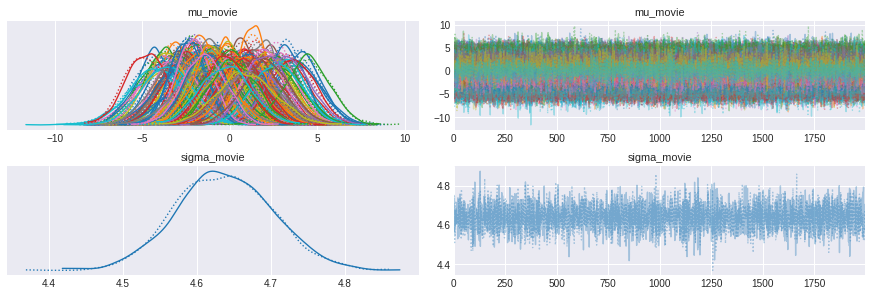

In [ ]:
import arviz 
sample_count = 2000

with pm.Model() as model:
    sigma_movie = pm.Gamma('sigma_movie', alpha=10, beta=5)
    mu_movie = pm.Normal('mu_movie', mu=0.0, sigma=sigma_movie, shape=n_films)

    film_mark = pm.Normal('film_mark',
                          mu=mu_movie[ids],
                          sigma=sigma_movie,
                          observed=data['like'])
    
    trace = pm.sample(sample_count)
    az.plot_trace(trace)


    summary = az.summary(trace)

    marks = summary.iloc[:-1,:]
    marks['film_id'] = ids.unique() 
    marks.sort_values(by=['mean'], inplace=True, ascending=False)
    display(marks)


## Na 4.0

Niektóre osoby są większymi fanami kina niż inne. Co więcej, kryteria przyznawania tej samej oceny różnią się pomiędzy ludźmi. Ponadto jedne gatunki bywają raczej lepiej oceniane od innych. Rozszerz model o dodatkowe składniki uwzględniające te efekty.

Do średniej dla rozkładu $\mathit{O}_{i,o,g}$ dodaj odpowiednie składniki:

$\mathit{O}_{i,o,g} \sim N(\mu_i + \mu_o + \mu_g, \sigma_{movie})$

gdzie $\mu_o$ oznacza jak ostro ocenia dana osoba i pochodzi z rozkładu

$\mu_o \sim N(0, \sigma_{person})$

zaś $\mu_g$ oznacza jak ostro oceniane są filmy z danego gatunku:

$\mu_g \sim N(0, \sigma_{genre})$.

Przyjmij
```
sigma_person = pm.Gamma('sigma_person', alpha=10, beta=5)
sigma_genre = pm.Gamma('sigma_genre', alpha=10, beta=5)
```

Który gatunek cieszy się największą populatnością a który najmniejszą? Która osoba najbardziej krytycznie ocenia filmy?

Spróbuj usunąć z bazy wszystkie oceny wybranego filmu i zobacz jak to wpłynie na wynik (ocenę usuniętego filmu -- średnią i przedział HPD).

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [mu_genre, sigma_genre, mu_person, sigma_person, mu_movie, sigma_movie]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 46 seconds.
The number of effective samples is smaller than 10% for some parameters.


Describing movie summary


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_movie[0],4.262,0.964,2.497,6.091,0.022,0.016,1987.0,2327.0,1.0
mu_movie[182],4.114,1.099,2.164,6.252,0.026,0.018,1798.0,2443.0,1.0
mu_movie[80],4.063,1.128,1.839,6.099,0.024,0.017,2210.0,2490.0,1.0
mu_movie[174],3.575,1.140,1.533,5.778,0.022,0.015,2758.0,2788.0,1.0
mu_movie[20],3.421,1.054,1.507,5.405,0.028,0.020,1376.0,1777.0,1.0
mu_movie[94],3.382,1.070,1.382,5.396,0.025,0.018,1780.0,2612.0,1.0
mu_movie[41],3.168,1.012,1.373,5.160,0.022,0.016,2077.0,2688.0,1.0
mu_movie[164],3.037,1.027,0.946,4.836,0.024,0.018,1830.0,1948.0,1.0
mu_movie[28],2.988,1.025,1.023,4.881,0.023,0.016,2017.0,2153.0,1.0
mu_movie[149],2.941,1.001,1.079,4.819,0.023,0.016,1883.0,2331.0,1.0


Describing person summary


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_person[20],4.435,0.573,3.380,5.508,0.030,0.021,373.0,758.0,1.00
mu_person[19],4.316,0.562,3.316,5.433,0.031,0.022,335.0,659.0,1.01
mu_person[0],3.658,0.594,2.650,4.864,0.029,0.020,426.0,757.0,1.00
mu_person[16],3.628,0.582,2.559,4.735,0.030,0.021,372.0,743.0,1.00
mu_person[8],3.584,0.572,2.511,4.667,0.030,0.022,354.0,772.0,1.00
mu_person[3],3.039,0.565,1.982,4.115,0.030,0.021,364.0,765.0,1.01
mu_person[22],2.474,0.582,1.393,3.562,0.030,0.021,389.0,709.0,1.01
mu_person[15],1.627,0.577,0.508,2.660,0.030,0.021,380.0,899.0,1.00
mu_person[2],1.484,0.583,0.429,2.579,0.030,0.022,366.0,749.0,1.01
mu_person[10],0.635,0.565,-0.342,1.760,0.028,0.020,397.0,755.0,1.00


Describing genre summary


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_genre[4],0.599,0.648,-0.632,1.800,0.030,0.021,467.0,743.0,1.01
mu_genre[3],0.574,0.649,-0.671,1.733,0.031,0.022,434.0,951.0,1.01
mu_genre[1],-0.031,0.719,-1.398,1.311,0.040,0.028,325.0,610.0,1.01
mu_genre[2],-0.184,0.624,-1.353,1.023,0.031,0.022,417.0,572.0,1.01
mu_genre[0],-1.686,0.617,-2.756,-0.493,0.031,0.022,406.0,719.0,1.00


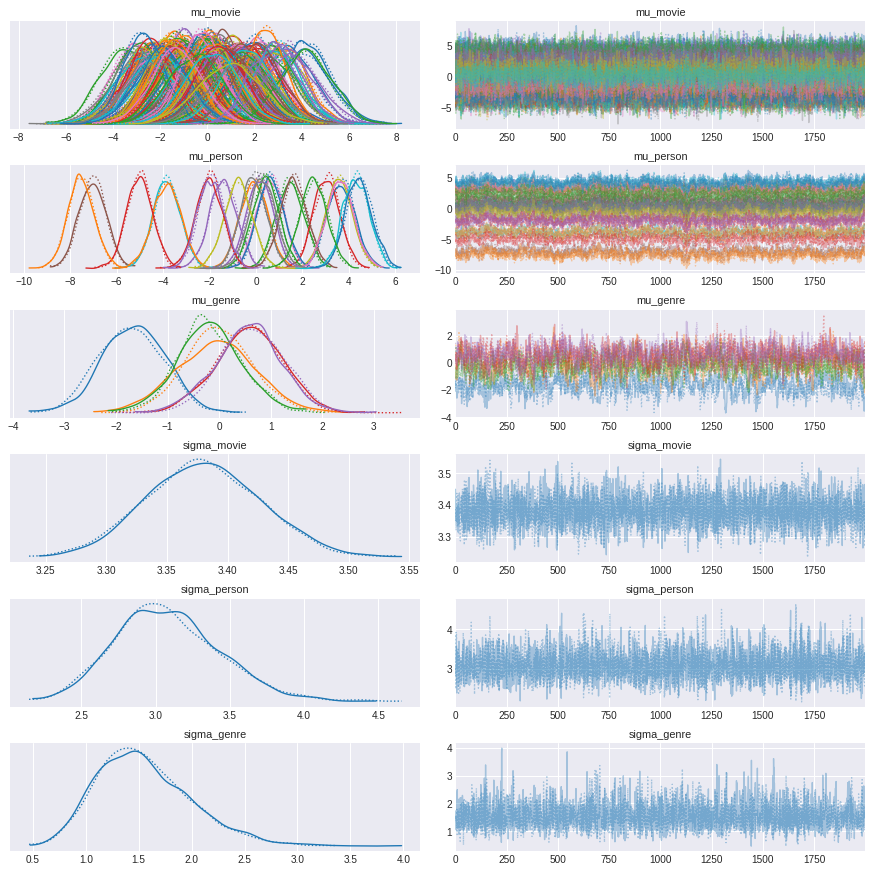

In [ ]:
movie =data['movie']
person =data['person']
genre = data['genre']
sample_count = 2000



sample_count_4 = 2000

with pm.Model() as model_4:
    def variables(variable_name, ids):
      sig = pm.Gamma(f'sigma_{variable_name}', alpha=10, beta=5)
      N = ids.unique().shape[0]
      MU= pm.Normal(f'mu_{variable_name}', mu=0.0, sigma=sig, shape=N)
      return sig, MU, N

    sigma_movie, mu_movie, movie_count = variables('movie', movie)
    sigma_person, mu_person, person_count =variables('person', person)
    sigma_genre, mu_genre, genre_count = variables('genre', genre)

    film_mark = mu_genre[genre] + mu_person[person] + mu_movie[movie] 
    
    
    mark = pm.Normal('film_mark',
                            mu=film_mark,
                            sigma=sigma_movie,
                            observed=data['like'])
    
        
    trace = pm.sample(sample_count)
    arviz.plot_trace(trace)

    sum = arviz.summary(trace)
    def summary(name, start_idx, count):
      print(f'Describing {name} summary')
      summary_to_describe = sum.iloc[start_idx:start_idx+ count, :]
      summary_to_describe.sort_values(by=['mean'], inplace=True, ascending=False)
      display(summary_to_describe)
    
    summary('movie', 0, movie_count)
    summary('person', movie_count, person_count)
    summary('genre', movie_count+person_count, genre_count)
    
   